# Задача

Выяснить, от каких самых малоприбыльных рейсов из Анапы можно отказаться в зимнее время.

За "зименее время" будем считать 3 месяца 2017 года - январь, февраль, декабрь.





# Описание датасета

При подготовке SQL запроса:
1. Определены модели самолетов, которые совершали рейсы в интересующий период времени.
2. Определены пункты назначения (аэропорты), в которые совершались нужные рейсы.
3. Определено расстояние между Анапой и пунктами назначения.
4. Для каждой модели самолёта определён расход топлива.
5. Определена средняя стоимость топлива в аэропорту Анапы для каждого из зимних месяцев 2017 года.
6. Для каждого рейса вычислен расход топлива и его стоимость (в закупочных ценах аэропорта Анапы).
7. Для каждого рейса вычислено общее количество проданных билетов.
>При подготовке датасета было также выделено в отдельные поля количество проданных билетов в разные классы обслужвания (в зимние месяцы 2017 года в самолетах, совершавших вылеты из Анапы, было только 2 класса обслуживания - Бизнес и Эконом). Однако в итоговой датасет было решено вывести только общее количество проданных билетов. Выделение статистики по отдельным классам было бы обосновано в том случае, если бы перед нами стояла задача оптимизации тарифной политики, анализа именно классов обслуживания, а не всех рейсов целиком.

8. Вычислена доходность рейса в первом приближении = выручка от продажи билетов - затраты на топливо.
>Очевидно, что в рамках данного исследования затруднительно исследовать всю структуру постоянных и переменных затрат (всевозможные аэропортовые сборы, фонд оплаты труда сотрудников, лизинговые платежи и т.д.). И хотя, в процессе подготовки датасета были найдены действующие в зимние месяцы 2017 года препрейскуранты на обслуживание воздушных судов в аэропортах Анапы, Москвы, Новокузнецка и Белгорода, было решено отказаться от их использования. Сложно точно определить пункты, по которым осуществлялось обслуживание, а разница в стоимости сопоставимых услуг в разных аэропортах разнится не слишком существенно. Чтобы не загромождать исследование, в рассчёте доходности рейса было решено ограничиться использованием затрат только на топливо. К тому же именно расходы на топливо составляют существенную часть всех расходов на перевозку.

10. Вычислено значение пассажиро-километра для каждого рейса (произведение количества перевезённых пасажиров на расстояние в километрах - pkm) и прибыль на 1 pkm


Поля итогового датасета:


1. `flight_id*` -- идентификатор рейса
2. `departure_city*` -- город вылета
3. `arrival_city*` -- город прилёта
4. `ticket_total` -- продано билетов на рейс
4. `model` -- модель самолёта
5. `fullness` -- заполненность рейса, %
6. `month_flight` -- месяц рейса
7. `week_day` -- день недели (1-понедельник... 7-воскресенье)
8. `profit` -- прибыль тыс. руб. (разница между выручкой за билеты и затратами на топливо)
12. `profit_pkm` -- прибыль на 1 пассажиро-километр

* обязательные поля


# Импорт библиотек

In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Функции

In [369]:
def abs_tangent(df,lp, lv):
    '''
    Многофакторный ABC-анализ по нескольким параметрам методом касательных
    lp - список параметров
    lv - список значений факторов
    '''
    df_lf = df.groupby(lp,as_index=False)[lv].sum()

    for col in df_lf.columns:
        if col in list_values:
            dict_sum = {}
            dict_count = {}
            col_name = 'Group '+ col
            s = df_lf[col].sum()
            c = df_lf[col].count()
            df_lf[col_name] = np.where(df_lf[col] <= 0, '', np.where(df_lf[col] * c >= s, 'AB','BC'))
            pivot = df_lf.groupby(col_name, as_index=False).agg(Сумма=(col,'sum'),
                                                                Количество=(col_name,'count'))
            ab_sum = pivot[pivot[col_name] == 'AB']['Сумма'].iloc[0]
            bc_sum = pivot[pivot[col_name] == 'BC']['Сумма'].iloc[0]
            ab_count = pivot[pivot[col_name] == 'AB']['Количество'].iloc[0]
            bc_count = pivot[pivot[col_name] == 'BC']['Количество'].iloc[0]

            df_lf[col_name] = np.where(df_lf[col_name] == '', 'D',
                                       np.where(df_lf[col_name] == 'AB', np.where(df_lf[col] * ab_count > ab_sum,'A','B'), 
                                                np.where(df_lf[col] * bc_count > bc_sum,'B','C')))
            
    df_lf['Cons_group'] = ''
    l = ['Group ' + v for v in list_values]

    for col in df_lf.columns:
            if col in l:
                df_lf['Cons_group'] = df_lf['Cons_group'] + df_lf[col]
    df_lf.drop(list_values, axis=1, inplace=True)

    return df_lf




def get_boxplot(df,column,ax_y):
    '''
    График плотности распределения переменных для количественного признака
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()




def bad_flights(df,direction,list_val):
    '''
    Функция выявляет выбросы ниже нижней границы межквартильного размаха, по
    каждой группе параметра, возвращает фрейм, удовлетворяющий этим условиям.
    df - исходный фрейм
    direction - txt, название параметра
    list_val - список колонок для поиска выбросов
    '''
    s = set() # множество для накопления
    l = set(df[direction]) # уникальные значения параметра
    
    for col in df.columns:
        if col in list_val:
            for i in l:
                ss = set()
                ar = df[df[direction] == i][col].values
                Q1 = np.percentile(ar, 25, interpolation='lower')
                Q3 = np.percentile(ar, 75, interpolation='lower')
                IQR = Q3 - Q1
                out = Q1 - 1.5*IQR
                ss = set(df['flight_id'][(df[direction] == i) & (df[col] < out)])
                s |= ss
    df_filter = df[df['flight_id'].isin(s)]
    return df_filter



def get_map_barplot(df,col,name_x,l_values):
    for lvi in l_values:
        list_order = list(set(df[name_x])) # уникальные значения параметра
        g = sns.FacetGrid(df, col=col, height=4, aspect=.5)
        g.map(sns.barplot, name_x, lvi, order=list_order,palette='Set2');


# Импорт данных

In [370]:
# Основной датасет
avia = pd.read_csv('full_request.csv')

# Первичный осмотр данных

In [371]:
display(avia.sample(2),avia.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       127 non-null    int64  
 1   departure_city  127 non-null    object 
 2   arrival_city    127 non-null    object 
 3   ticket_total    118 non-null    float64
 4   model           127 non-null    object 
 5   fullness        118 non-null    float64
 6   month_flight    127 non-null    int64  
 7   week_day        127 non-null    float64
 8   profit          118 non-null    float64
 9   profit_pkm      118 non-null    float64
dtypes: float64(5), int64(2), object(3)
memory usage: 10.0+ KB


,flight_id,departure_city,arrival_city,ticket_total,model,fullness,month_flight,week_day,profit,profit_pkm
42,136755,Anapa,Belgorod,97.0,Sukhoi Superjet-100,1.000000,1,6.0,716.38,11.59
3,136209,Anapa,Moscow,112.0,Boeing 737-300,0.861538,1,5.0,1465.58,10.64


None

В данных есть пропуски - нет данных о стоимости проданных билетов (а следовательно и об общей доходности) на 9 рейсов.
Посмотрим, что это за рейсы:

In [372]:
avia[avia['profit'].isna()]

,flight_id,departure_city,arrival_city,ticket_total,model,fullness,month_flight,week_day,profit,profit_pkm
13,136523,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,1,2.0,NaN,NaN
14,136511,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,2,2.0,NaN,NaN
15,136546,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,1,2.0,NaN,NaN
16,136540,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,1,2.0,NaN,NaN
48,136560,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,1,2.0,NaN,NaN
86,136514,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,2,2.0,NaN,NaN
87,136513,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,2,2.0,NaN,NaN
88,136567,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,2,2.0,NaN,NaN
126,136544,Anapa,Novokuznetsk,NaN,Boeing 737-300,NaN,1,2.0,NaN,NaN


Это 9 рейсов в Новокузнецк. Посмотрим как распределены рейсы по городам:

In [373]:
avia.groupby(['arrival_city'])['flight_id'].count()

arrival_city
Belgorod        59
Moscow          59
Novokuznetsk     9
Name: flight_id, dtype: int64

Получается, что что у нас полностью отсутствуют данные о финансовой составляющей целого направления перелётов. Возможно это ошибка в базе данных, а возможно, что это были какие-то специальные рейсы...

При подготовке выгрузки датасета из базы данных была также исследована таблица бронирований, содержащая общую стоимость для каждого бронирования - она так же не содержит финансовых данных об этих 9-ти рейсах.

Можно было бы попытаться восстановить пропущенные данные заполнив их средним или медианным значением для данной модели самолета, но скорее всего это внесёт существенные искажения, так-как: 
* Новокузнецк находится на значительно большем расстоянии от Анапы, чем Белгород и Москва 
* Из-за расстояния стоимость билетов в Новокузнецк должна быть существенно выше, а мы не знаем точных принципов ценообразования на билеты.

Следовательно, от пропущенных данных нужно отказаться.

In [374]:
avia.dropna(inplace=True)

# Определение целей.
Оптимизация предполагает повышение значений одного или нескольких показателей при допустимом (заданном) понижении другого (других).

Для сферы авиаперевозок, вероятно, ключевыми показателями будут:
* доходность (как целого направления (маршрута), так и отдельных рейсов в нём;
* количество перревезённых пассажиров и грузов.

Таким образом, в соответствии с поставленной задачей, нам необходимо определить наименее прибыльные рейсы, отказавшись от проведения которых авиакомпания в наименьшей степени потеряла бы в объёме перевозок.

  



## month_flight
В какие месяцы совершались полёты:

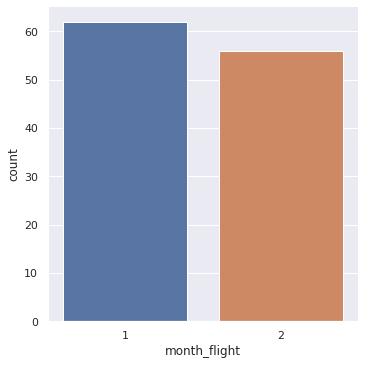

In [375]:
sns.catplot(x="month_flight", kind="count", data=avia);

У нас есть данные только за январь и февраль 2017 года.

## week_day

Сначала посмотрим на загруженность и среднее количество реализуемых билетов  по дням недели и по направлениям. Возможно будет выявлено нераравномерное распределение.

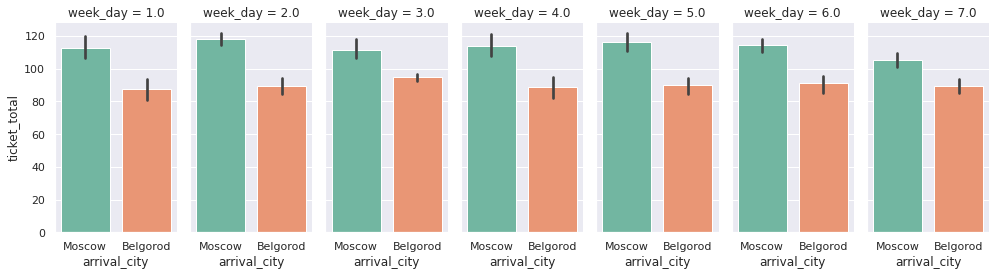

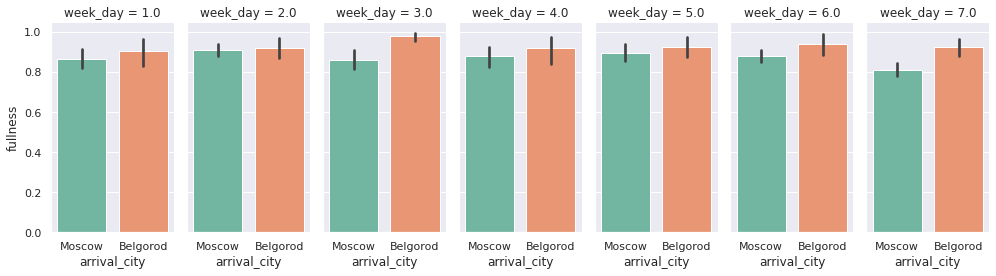

In [376]:
get_map_barplot(avia,'week_day','arrival_city',['ticket_total','fullness'])

В Москву билетов продаётся в среднем больше, но средняя загруженность рейсов в Белгород выше.

Посмотрим на распределение заполненности рейсов по дням недели. 

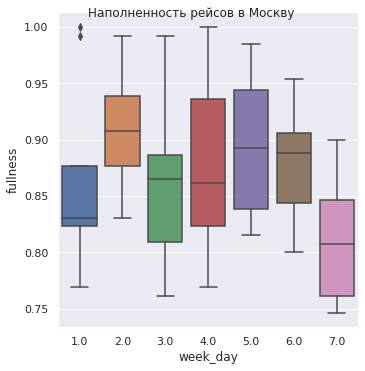

In [377]:
g = sns.catplot(x='week_day', y='fullness', kind="box", data=avia[avia['arrival_city']=='Moscow'])
g.fig.suptitle('Наполненность рейсов в Москву', fontsize=12);

В направлении Москвы загруженность рейсов ниже всего в воскресенье - вероятно это связано с тем, что пассажиры, летящие через Москву транзитом, планируют прибыть в пункт назначения до начала рабочей недели - медиана заполненности рейсов в воскресенье чуть выше 80%.

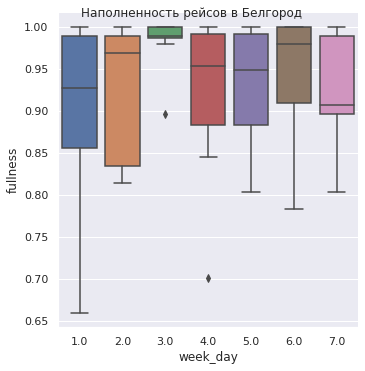

In [378]:
g = sns.catplot(x='week_day', y='fullness', kind="box", data=avia[avia['arrival_city']=='Belgorod']);
g.fig.suptitle('Наполненность рейсов в Белгород', fontsize=12);

В направлении Белгорода загруженность больше, наименьшее значение медианы также в воскресенье, но выделятся понедельник (самое низкое значение заполненности - порядка 66%) и четверг (выброс - единичный рейс с заполненностью около 70%). Это потенциальные кандидаты на роль "плохих рейсов" (не дни  недели, а рейсы с такими значениями).

Однако, необходимо посмотреть на взаимосвязь прибыльности и заполненности этих рейсов.

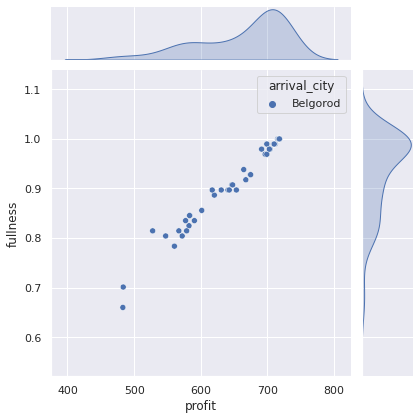

In [353]:
sns.jointplot(x='profit', y='fullness', data=avia[avia['arrival_city']=='Belgorod'], hue='arrival_city');

2 рейса в Белгород имеют заметно меньшуую наполненность и прибыльность.

В целом нельзя выделить какие-либо "незагруженные" дни недели. Поэтому отпадает наиболее простой вариант - выявить день недели в котроый совершаются наименее прибыльные рейсы.

## profit

Посмотрим на распределение прибыльности рейсов

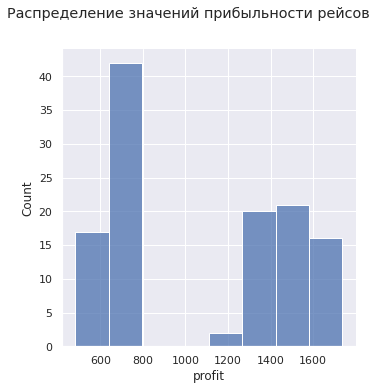

In [354]:
g = sns.displot(avia['profit']);
g.fig.suptitle('Распределение значений прибыльности рейсов', y=1.08);

Видно 2 группы, посмотрим на взаимосвяззь колличества проданных билетов и прибыльности рейса по городам:

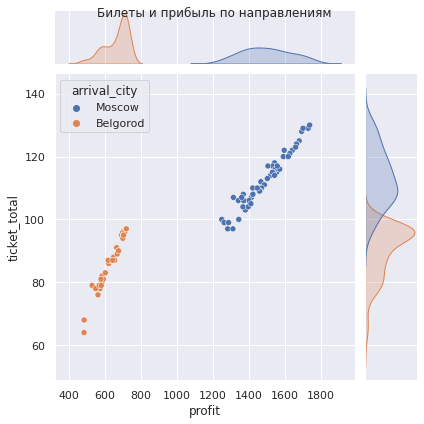

In [355]:
g = sns.jointplot(x='profit', y='ticket_total', data=avia, hue='arrival_city')
g.fig.suptitle('Билеты и прибыль по направлениям', fontsize=12);

Возможно, в каждый из городов летает только одна модель самолёта? Проверяем:

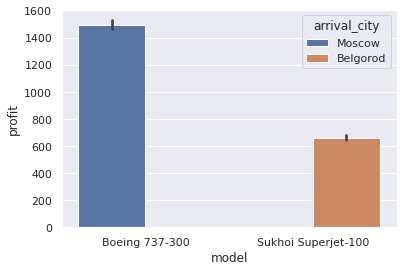

In [356]:
sns.barplot(x='model', y='profit', hue='arrival_city', data=avia);

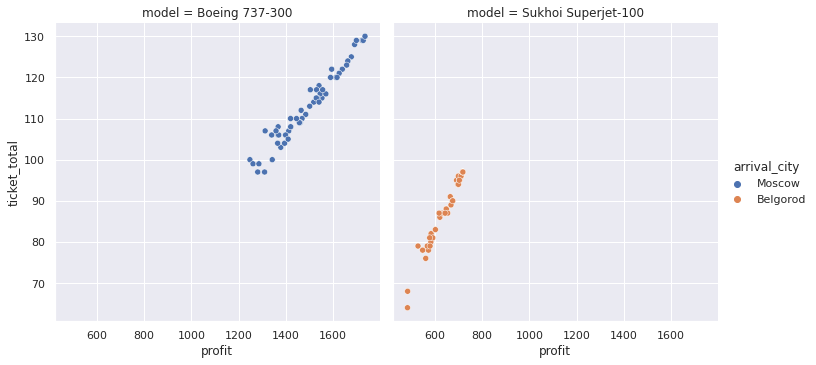

In [357]:
g = sns.relplot(x='profit', y='ticket_total', hue='arrival_city', col='model', data=avia);

Это действительно так.
Посмотрим - есть ли выбросы в распределении прибылии по моделям самолётов (=по маршрутам полётов)

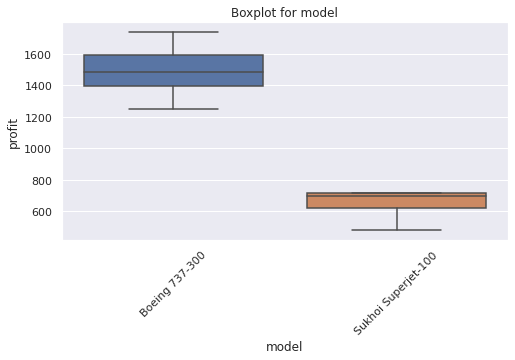

In [358]:
get_boxplot(avia,'model','profit');

Выбросов нет, распределение прибыли нормальное.



На этом этапе может показаться, что логично отказаться от рейсов в Белгород, либо от рейсов, на которых используется Superjet-100 (в нашем случае это одно и то же).

Но, по имеющейся информации (впрочем, этот вопрос дискуссионный) Superjet-100 по расходу топлива - экономичнее, чем Boeing 737-300.

Чтобы проверить это, необходимо рассмотреть другой параметр - прибыль на 1 пассажиро-километр.




## profit_pkm, fullness 

Рассмотрим это параметр в связке с другим показательным параметром `fullness` - заполненностью рейса пассажирами (1 - все билеты распроданы, свободных мест нет)



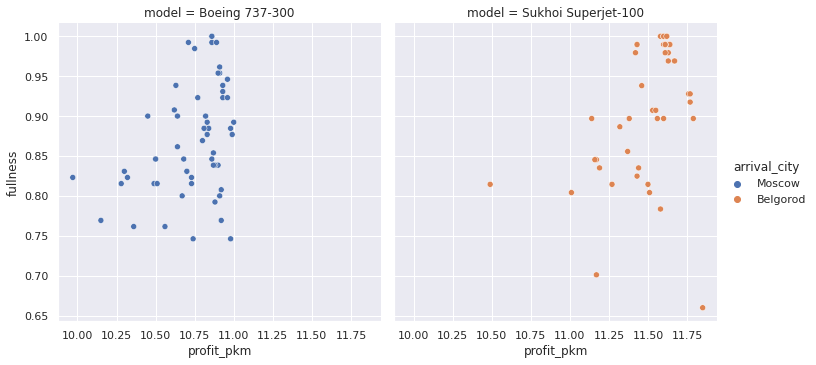

In [359]:
sns.relplot(x='profit_pkm', y='fullness', hue='arrival_city', col='model', data=avia);

Здесь картина обратная. В пересчёте прибыльности на 1 пассажиро-километр рейсы в Белгород достаточно прибыльны. Так же, по показателю наполнености самолёта выдаляются 2 рейса в Белгород - примерно 70 и 66 %%. Но по прибыли на 1 пассажиро-километр один из рейсов даже в лидерах.



Теперь посмотрим на статистические значения признаков (так как в наших данных с точки зрения группировки данных город прилёта = модель самолёта, будем использовать только одну категорию)

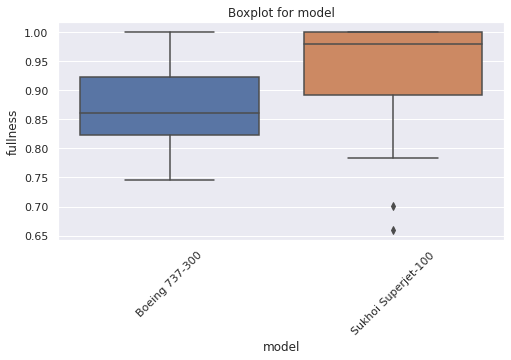

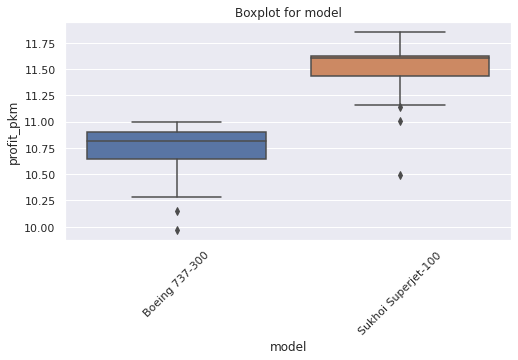

In [360]:
yl =['fullness','profit_pkm']
for y in yl:
    get_boxplot(avia,'model',y)
    print('')

* `fullness` - заполненность самолёта
>Видно, что Superjet летает более заполненным, чем Boing, его медианное значение близко к 100%. Но есть и 2 мало заполненных рейса. И хотя заполнность рейса - важный экономический показатель, но применитьельно к данной задаче - он играет второстепенную роль (самолет может быть мало наполнен, но при этом могут быть распроданы наиболее дорогие билеты).

* `profit_pkm`
> Как уже было отмечено выше - прибыль на 1 пассажиро-километр - даёт иную картину. Для Superjet-100 она в целом выше. График также показывает 5 выбросов значений (в меньшую от медианы сторону). Это 3 рейса "Сухого" и 2 рейса "Боинга".

# ВАРИАНТ 1
Наименее прибыльные рейсы, от которых следует отказаться - это рейсы, совершенные по каждому направлению, у которых значение прибыли одного пассажиро-километра или наполненность меньше нижней границы межквартильного размаха.

Воспользуемся функцией `bad_flights` - определим рейсы с выбросами в меньшую сторону по заданным показателям - направление, наполненность и прибыль на 1 пассажиро-километр.

In [361]:
df_bad1 = bad_flights(avia,'arrival_city',['fullness','profit_pkm'])
df_bad1

,flight_id,departure_city,arrival_city,ticket_total,model,fullness,month_flight,week_day,profit,profit_pkm
21,136464,Anapa,Moscow,100.0,Boeing 737-300,0.769231,1,1.0,1248.38,10.15
28,136844,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,2.0,527.72,10.49
31,136204,Anapa,Moscow,107.0,Boeing 737-300,0.823077,2,4.0,1312.89,9.97
54,136666,Anapa,Belgorod,87.0,Sukhoi Superjet-100,0.896907,2,4.0,617.12,11.14
72,136887,Anapa,Belgorod,78.0,Sukhoi Superjet-100,0.804124,1,5.0,547.26,11.01
84,136807,Anapa,Belgorod,68.0,Sukhoi Superjet-100,0.701031,2,4.0,483.62,11.17
103,136642,Anapa,Belgorod,64.0,Sukhoi Superjet-100,0.659794,1,1.0,483.06,11.85


Таким образом, в соответствии с этим вариантом решения выявлены 7 наименее прибыльных рейса (по полученной прибыли в расчёте на один пассажиро-километр).

# ВАРИАНТ 2

## ABC-анализ

Одним из подходов к определению наименее прибыльных рейсов межет быть проведение многофакторного ABC-анализа.  Это метод, позволяющий классифицировать факторы по степени их вклада в общий результат.

При таком подходе основная задача - правильно определить значимые факторы. Чем выше будет значение фактора, тем большее значение он будет иметь в структуре авиаперевозок.

В классическом виде при ABC-анализе жестко задаются границы групп. Но более гибким является определение границ групп методом касательных. В этом случае границы груп определяются динамически и метод проще применять при многофакторном анализе.

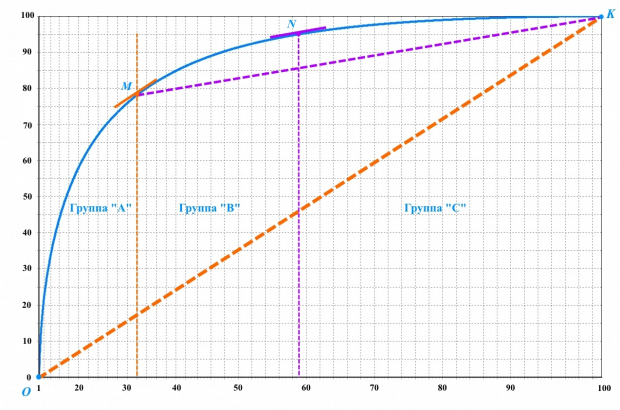

ABC-анализ будем проводить по связке следующих факторов:

* `flight_id` - идентификатор рейса

В качестве значений факторов будем использовать:

* `profit` - прибыль
* `ticket_total` - количество проданных билетов на рейс
* `fullness` - процент заполненности рейса
* `profit_pkm` - прибыль на 1 пассажиро-километр

Воспользуемся функцией `abs_tangent`. Она принимает на входе список фактров )`list_factors`) - переменные, которые будут анализироваться, (в нашем случае это `flight_id`) и список числовых параметров (`list_values`).

Каждый из элементов `list_factors` будет отнесен к одной из 3-х групп (A, B или С) в соотвтствии с той долей которрую имеет его значение в кумулятивной сумме каждого параметра из списка `list_values`.

В сводной группе (`Cons_group`) объединены результаты анализа по каждому из числовых параметров.

Результаты анализа можно фильтровать в соответствие с поставленными задачами.

In [362]:
list_factors = ['flight_id']
list_values = ['profit','profit_pkm','fullness','ticket_total']
df = abs_tangent(avia,list_factors,list_values)
df_abc = avia.merge(df, how='left', on=list_factors).sort_values(by='Cons_group')

In [363]:
reg = '[C][BC][C][C]' # если для параметра profit_pkm допустима только группа A
# reg = '[C][C][C][C]' # "Плохие рейсы" - только группы С по всем параметрам
mask = df_abc['Cons_group'].str.contains(reg, regex=True)
df_bad2 = df_abc[mask]
df_bad2

,flight_id,departure_city,arrival_city,ticket_total,model,fullness,month_flight,week_day,profit,profit_pkm,Group profit,Group profit_pkm,Group fullness,Group ticket_total,Cons_group
79,136807,Anapa,Belgorod,68.0,Sukhoi Superjet-100,0.701031,2,4.0,483.62,11.17,C,B,C,C,CBCC
50,136678,Anapa,Belgorod,80.0,Sukhoi Superjet-100,0.824742,1,6.0,582.28,11.43,C,B,C,C,CBCC
98,136888,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,2.0,578.72,11.50,C,B,C,C,CBCC
23,136823,Anapa,Belgorod,78.0,Sukhoi Superjet-100,0.804124,2,7.0,572.08,11.51,C,B,C,C,CBCC
94,136620,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,5.0,567.07,11.27,C,B,C,C,CBCC
67,136887,Anapa,Belgorod,78.0,Sukhoi Superjet-100,0.804124,1,5.0,547.26,11.01,C,B,C,C,CBCC
24,136844,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,2.0,527.72,10.49,C,C,C,C,CCCC


Результаты анализа (количество рейсов в разных группах) можно визуализировать.
При этом порядок литералов в кодовом обозначении группы (AAAA) соответсвует порядку параметров в списке `list_values`

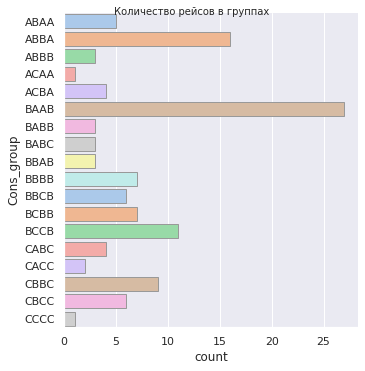

In [364]:
g = sns.catplot(y="Cons_group", kind="count", palette="pastel", edgecolor=".6", data = df_abc)
g.fig.suptitle('Количество рейсов в группах', fontsize=10);

Посмотрим на распределение направлений (=моделей самолётов) по группам в соответствии со списком значений параметров.

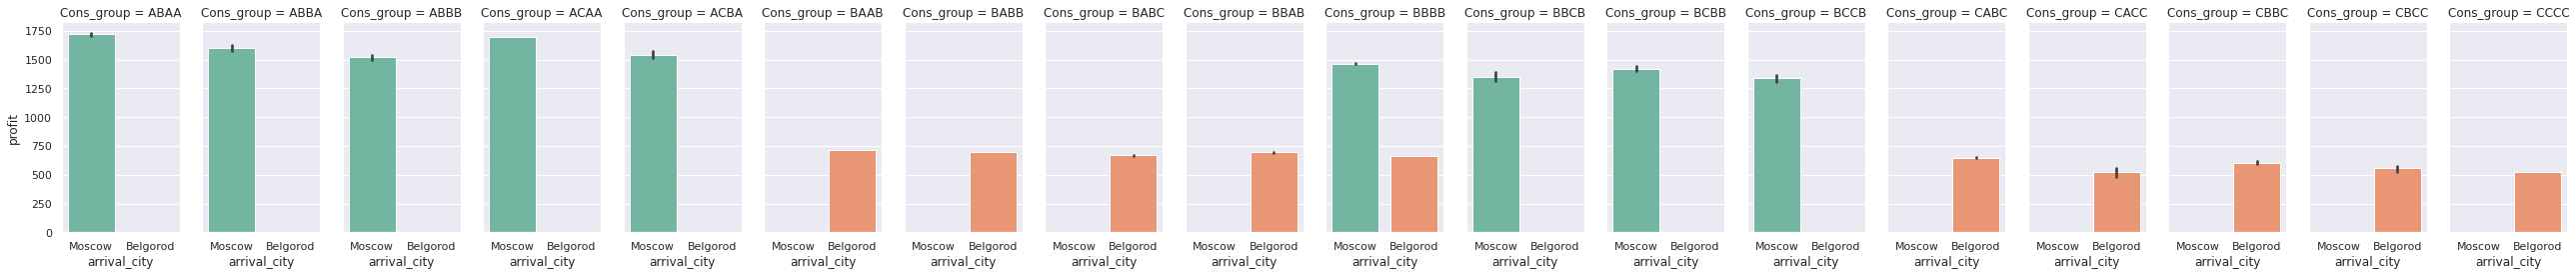

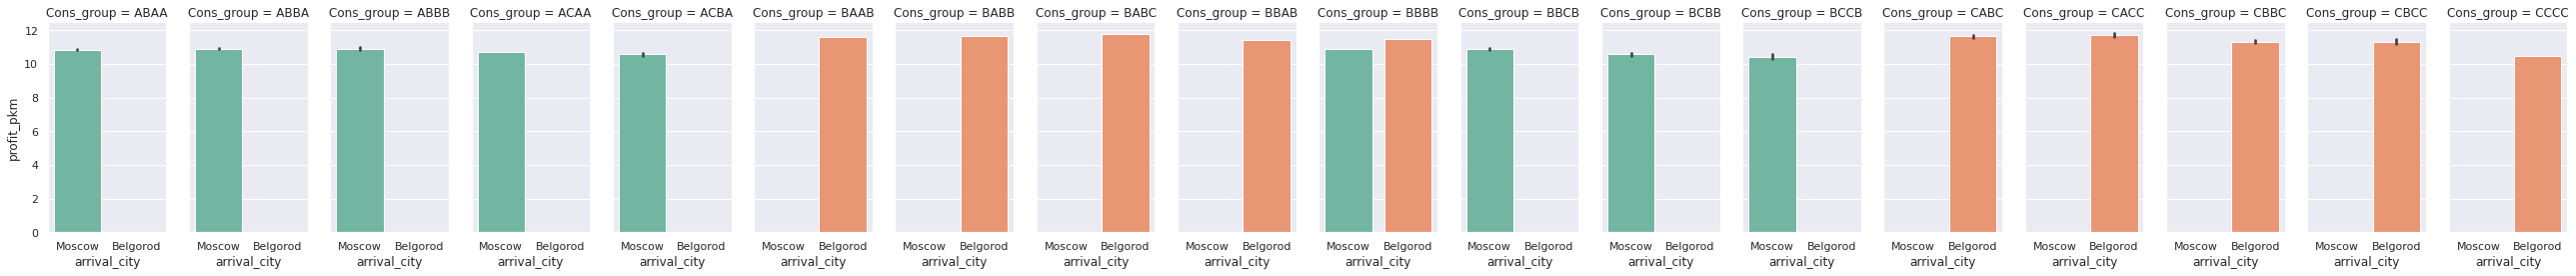

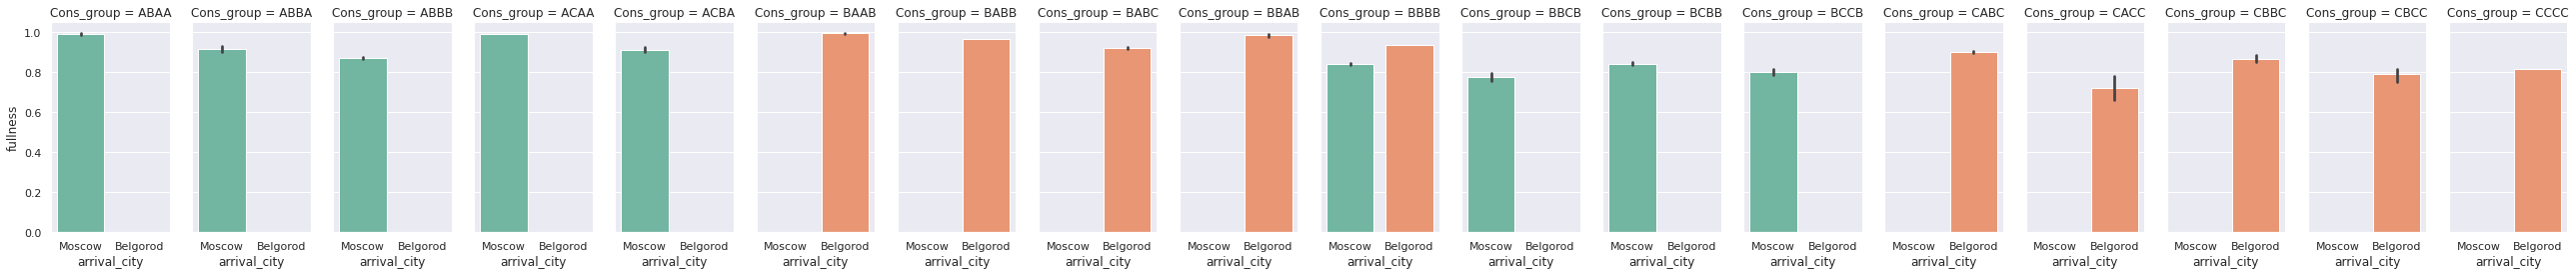

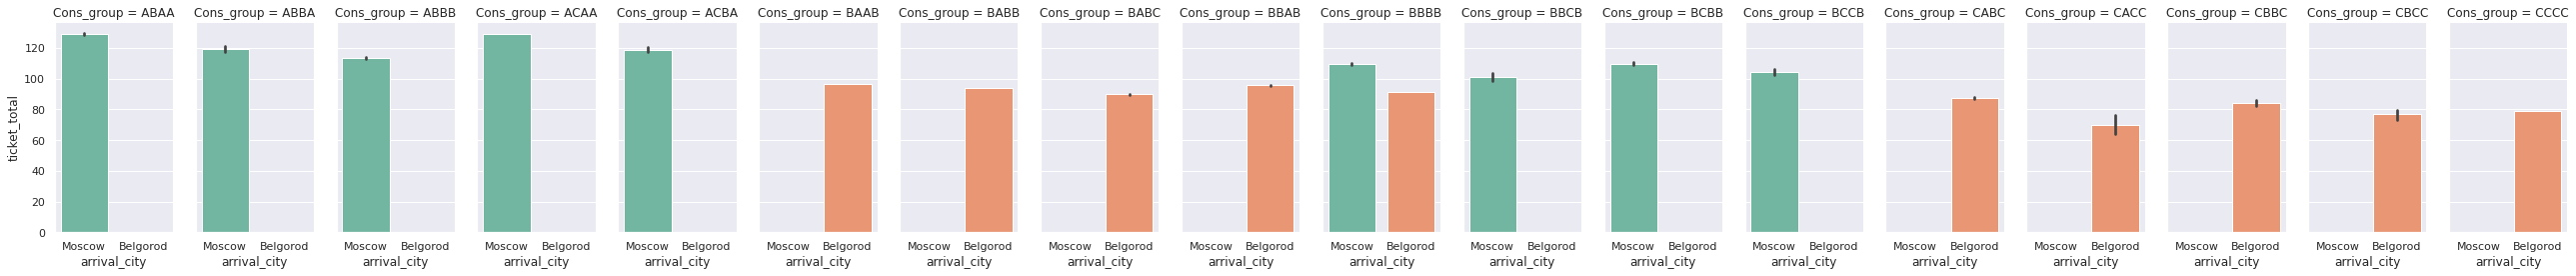

In [365]:
get_map_barplot(df_abc,'Cons_group','arrival_city',list_values)

# Итоги

Таким образом мы получили 2 частично пересекающихся фрейма данных с "плохими рейсами", полученными двумя разными методами. 

Какой из них применить - должно быть экспертное мнение специалиста.
 В качестве решения поставленной задачи можно предложить 2 варианта списка "плохих рейсов" - узкий и расширенный.

 * узкий список - в него войдут только рейсы, пересекающиеся по обоим фреймам
 * широкий список - все рейсы из обоих списков.

Так же можно использовать и любой из списков по отдельности.

## Узкий список

In [366]:
df_narrow =  df_bad1.merge(df_bad2)
df_narrow

,flight_id,departure_city,arrival_city,ticket_total,model,fullness,month_flight,week_day,profit,profit_pkm,Group profit,Group profit_pkm,Group fullness,Group ticket_total,Cons_group
0,136844,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,2.0,527.72,10.49,C,C,C,C,CCCC
1,136887,Anapa,Belgorod,78.0,Sukhoi Superjet-100,0.804124,1,5.0,547.26,11.01,C,B,C,C,CBCC
2,136807,Anapa,Belgorod,68.0,Sukhoi Superjet-100,0.701031,2,4.0,483.62,11.17,C,B,C,C,CBCC


## Широкий список

In [367]:
df_wide = df_bad1.merge(df_abc)
df_wide =  df_wide.merge(df_bad2, how='outer')
df_wide

,flight_id,departure_city,arrival_city,ticket_total,model,fullness,month_flight,week_day,profit,profit_pkm,Group profit,Group profit_pkm,Group fullness,Group ticket_total,Cons_group
0,136464,Anapa,Moscow,100.0,Boeing 737-300,0.769231,1,1.0,1248.38,10.15,B,C,C,B,BCCB
1,136844,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,2.0,527.72,10.49,C,C,C,C,CCCC
2,136204,Anapa,Moscow,107.0,Boeing 737-300,0.823077,2,4.0,1312.89,9.97,B,C,C,B,BCCB
3,136666,Anapa,Belgorod,87.0,Sukhoi Superjet-100,0.896907,2,4.0,617.12,11.14,C,B,B,C,CBBC
4,136887,Anapa,Belgorod,78.0,Sukhoi Superjet-100,0.804124,1,5.0,547.26,11.01,C,B,C,C,CBCC
5,136807,Anapa,Belgorod,68.0,Sukhoi Superjet-100,0.701031,2,4.0,483.62,11.17,C,B,C,C,CBCC
6,136642,Anapa,Belgorod,64.0,Sukhoi Superjet-100,0.659794,1,1.0,483.06,11.85,C,A,C,C,CACC
7,136678,Anapa,Belgorod,80.0,Sukhoi Superjet-100,0.824742,1,6.0,582.28,11.43,C,B,C,C,CBCC
8,136888,Anapa,Belgorod,79.0,Sukhoi Superjet-100,0.814433,2,2.0,578.72,11.50,C,B,C,C,CBCC
9,136823,Anapa,Belgorod,78.0,Sukhoi Superjet-100,0.804124,2,7.0,572.08,11.51,C,B,C,C,CBCC


# Дополнительное задание

Я бы предложил убрать рейсы из полученного "узкого списка" - df_narrow
* 136844
* 136887
* 136807


In [380]:
df_narrow['profit'].sum()*1000

1558600.0